In [18]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime

In [2]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

In [3]:
conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()

In [4]:
start_date = '2021-03-02'
end_date = '2021-04-01'

In [5]:
query = """
with osv as 
(
    select
        p.uid || '_' || t.transactionid as igniteID
        , max(dos.os) as osv 
    from rawdata.dt_transactions t
    join rawdata.dt_transactions_events te 
        on t.transactionid = te.transactionid
    join rawdata.dt_events e
        on e.eventid = te.eventid 
        and e.rs_carrier_id = te.rs_carrier_id
    join rawdata.dt_process p
        on t.processid = p.processid 
        and p.rs_carrier_id = t.rs_carrier_id 
        and p.processtypeid = 1
        and left(p.uid,1) = '0'
    left join rawdata.dt_device_os dos
        on dos.deviceosid = p.deviceosid
        and dos.rs_carrier_id = p.rs_carrier_id 
    where 
        date(te.eventdate) >= date('{start_date}') - 30
        and date(te.eventdate) <= '{end_date}'
    group by 1
) 
select 
    date
    , campaign_name
    , campaign_id 
    , partner_name 
    , osv
    , package_name
    , site_name
    , carrier_name
    , country_code
    , sum(preload)*16 as preload 
    , sum(install)*16 as install 
    , sum(d7_events)*16 as d7_events
    , sum(d7_rev)*16 as d7_rev 
    , sum(spend)*16 as spend 
from
(
    select
        date(ctp.tracking_time) as date
        , osv.osv 
        , c.campaign_id 
        , c.campaign_name
        , pi.partner_name 
        , pa.package_name
        , ctp.country_code
        , s.site_name
        , pi2.partner_name as carrier_name
        , count(distinct ctp.referrer) as preload
        , 0 as install
        , 0 as d7_events
        , 0 as d7_rev
        , sum(case when billing_type = 'CPP' then ctp.gross_payout else 0 end) as spend 
    from rawdata.campaign_tracking_active_preload ctp
    join rawdata.campaign c 
        on ctp.campaign_id = c.campaign_id 
        and c.bid_price_per_download > 0
    join rawdata.partner_app pa 
        on pa.id = c.app_id
        and pa.package_name = ctp.android_package_name
    join rawdata.partner_information pi
        on pi.partner_id = pa.partner_id 
    join rawdata.site s 
        on ctp.site_id = s.site_id
    left join rawdata.partner_information pi2
        on pi2.partner_id = s.partner_id 
    left join osv 
        on ctp.reqid = osv.igniteID
    where 
        date(ctp.tracking_time) >= '{start_date}'
        and date(ctp.tracking_time) <= '{end_date}'
        and left(ctp.reqid,1) = '0'
    group by 1,2,3,4,5,6,7,8,9

    union all

    select
        date(cti.tracking_time) as date
        , osv.osv
        , c.campaign_id 
        , c.campaign_name
        , pi.partner_name 
        , pa.package_name
        , cti.country_code
        , s.site_name
        , pi2.partner_name as carrier_name
        , 0 as preload
        , count(distinct cti.referrer) as install
        , 0 as d7_events
        , 0 as d7_rev
        , sum(case when billing_type = 'CPI' then cti.gross_payout else 0 end) as spend 
    from rawdata.campaign_tracking_active_install cti 
    join rawdata.campaign c 
        on cti.campaign_id = c.campaign_id 
        and c.bid_price_per_download > 0
    join rawdata.partner_app pa 
        on pa.id = c.app_id
        and pa.package_name = cti.android_package_name
    join rawdata.partner_information pi
        on pi.partner_id = pa.partner_id 
    join rawdata.site s 
        on cti.site_id = s.site_id
    left join rawdata.partner_information pi2
        on pi2.partner_id = s.partner_id 
    left join osv 
        on cti.reqid = osv.igniteID
    where 
        date(cti.tracking_time) >= '{start_date}'
        and date(cti.tracking_time) <= '{end_date}'
        and left(cti.reqid,1) = '0'
    group by 1,2,3,4,5,6,7,8,9

    union all 

    select
        date(cti.tracking_time) as date
        , cti.osv
        , cti.campaign_id 
        , cti.campaign_name
        , cti.partner_name 
        , cti.package_name
        , cti.country_code 
        , site_name
        , carrier_name
        , 0 as preload
        , 0 as install
        , count(distinct pi.referrer) as d7_events
        , sum(case when event_var ~ '^[-+]?([0-9]*\.[0-9]+|[0-9]+)$' then event_var else 0::varchar END) as d7_rev
        , 0 as spend 
    from rawdata.pi_data pi 
    join 
    (
        select 
            referrer 
            , tracking_time 
            , osv.osv
            , c.campaign_id 
            , c.campaign_name
            , pi.partner_name 
            , pa.package_name
            , country_code
            , s.site_name
            , pi2.partner_name as carrier_name
        from rawdata.campaign_tracking_active_install cti 
        join rawdata.campaign c 
            on cti.campaign_id = c.campaign_id 
            and c.bid_price_per_download > 0
        join rawdata.partner_app pa 
            on pa.id = c.app_id
            and pa.package_name = cti.android_package_name
        join rawdata.partner_information pi
            on pi.partner_id = pa.partner_id 
        join rawdata.site s 
            on cti.site_id = s.site_id
        left join rawdata.partner_information pi2
            on pi2.partner_id = s.partner_id 
        left join osv 
            on cti.reqid = osv.igniteID
        where 
            date(cti.tracking_time) >= '{start_date}'
            and date(cti.tracking_time) <= '{end_date}'
            and left(cti.reqid,1) = '0'
        group by 1,2,3,4,5,6,7,8,9,10
    ) cti
        on cti.referrer = pi.referrer
        and datediff(day, cti.tracking_time::timestamp, pi.event_date::timestamp) <= 7
        and pi.event_date >= cti.tracking_time      
    where 
        date(event_date) >= '{start_date}'
        and date(event_date) <= date('{end_date}') + interval '7 day'
        and (lower(pi.event) like '%purchase%'
            or lower(pi.event) like '%order%'
            or lower(pi.event) like '%revenue%'
            or (event_var ~ '^[-+]?([0-9]*\.[0-9]+|[0-9]+)$'
            and event_var != 0)) 
        and lower(pi.event) not like '%reorder%'
        and lower(pi.event) not like '%refund%'
        and lower(pi.event) not like '%cancel%'
    group by 1,2,3,4,5,6,7,8,9
) t
group by 1,2,3,4,5,6,7,8,9
"""

In [6]:
cur_atlas.execute(query.format(start_date = start_date, end_date = end_date))
df = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [35]:
def find_low_osv(r):
    try:
        return (int(r.split('.')[0]) <= 8)
    except:
        return True

df['low_osv'] = df['osv'].apply(lambda r:find_low_osv(r))
df['spend'] = df['spend'].astype(float)
df['d7_rev'] = df['d7_rev'].astype(float)
df['carrier_name_no_country'] = df['carrier_name'].str.replace(' [A-Z][A-Z] ',' ').str.replace(' [A-Z][A-Z]$','')
by_package = df.pivot_table(values = ['d7_events','spend'], index = 'package_name', columns = 'low_osv', aggfunc = np.sum)
by_package.columns = ['d7_events_not_low_osv','d7_events_low_osv','spend_not_low_osv','spend_low_osv']
by_package['d7_cpa_not_low_osv'] = by_package['spend_not_low_osv']/by_package['d7_events_not_low_osv']
by_package['d7_cpa_low_osv'] = by_package['spend_low_osv']/by_package['d7_events_low_osv']

filter_optimizable = (by_package.d7_events_not_low_osv > 0) & ((by_package.d7_cpa_not_low_osv <= by_package.d7_cpa_low_osv) | ((by_package.d7_events_low_osv == 0) & (by_package.spend_low_osv >= by_package.d7_cpa_not_low_osv)))
packages_w_events = by_package.loc[filter_optimizable].index.to_list()
packages_w_events
df.groupby([df.package_name.isin(packages_w_events)]).sum()

<ipython-input-35-d3cfacf7d267>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['carrier_name_no_country'] = df['carrier_name'].str.replace(' [A-Z][A-Z] ',' ').str.replace(' [A-Z][A-Z]$','')


campaign_id   preload   install  d7_events     d7_rev  \
package_name                                                          
False         20307071129  84914128  16506576       6848   154224.0   
True           8113742081  35906160   5268704      69136  5875168.0   

                     spend  low_osv  
package_name                         
False         1.558367e+07   293062  
True          7.911403e+06   105385

In [47]:
by_package_low_osv = df[(df.package_name.isin(packages_w_events)) & (df.low_osv)].pivot_table(values = ['preload'], index = 'package_name', aggfunc = np.sum)
by_package_all = df.pivot_table(values = ['preload'], index = 'package_name', aggfunc = np.sum)
by_package = by_package_all.join(by_package_low_osv, how = 'left', lsuffix = '_total', rsuffix = '_low_osv')
by_package['pct_loss'] = round(by_package['preload_low_osv']/(by_package['preload_total']),2)
by_package['sov'] = round(by_package['preload_total']/by_package['preload_total'].sum(),3)
by_package[by_package.sov >= .001].sort_values(['pct_loss','preload_total'], ascending = False).head(30)

preload_total  \
package_name                                                        
com.wabi.customer                                           93040   
br.com.buscape.MainPack                                     68480   
com.king.farmheroessaga                                   2775072   
com.ea.gp.fifamobile                                       209664   
air.com.playtika.slotomania                               1518192   
com.king.candycrushsaga                                  11745200   
com.contextlogic.wish                                     6856144   
br.com.cea.appb2c                                          628112   
net.wooga.junes_journey_hidden_object_mystery_game          71904   
com.king.petrescuesaga                                     145904   
me.lyft.android                                            145296   
com.dd.doordash                                            299648   
com.king.candycrushsodasaga                               1388512   
com.bbumgames.rummystars                                   178528   
br.com.brainweb.ifood                                      878064   
com.gramgames.mergemagic                                   232096   
com.goodgamestudios.bigfarmmobileharvest                    72320   
com.gsn.android.tripeaks                                  3628256   
com.productmadness.cashmancasino                           255760   
com.productmadness.lightninglink                            85248   
com.gramgames.mergedragons                                1714800   
com.superplaystudios.dicedreams                            292864   
br.com.lojasrenner                                         218048   
de.autodoc.gmbh                                            178336   
com.innogames.foeandroid                                    90112   
net.supertreat.solitaire                                   542592   
com.wb.goog.got.conquest                                   202784   
com.luizalabs.mlapp                                        609456   
com.booking                                                248160   
br.com.petz                                                 72720   

                                                    preload_low_osv  pct_loss  \
package_name                                                                    
com.wabi.customer                                           55664.0      0.60   
br.com.buscape.MainPack                                     28272.0      0.41   
com.king.farmheroessaga                                    923472.0      0.33   
com.ea.gp.fifamobile                                        49312.0      0.24   
air.com.playtika.slotomania                                346432.0      0.23   
com.king.candycrushsaga                                   2542800.0      0.22   
com.contextlogic.wish                                     1295360.0      0.19   
br.com.cea.appb2c                                          110320.0      0.18   
net.wooga.junes_journey_hidden_object_mystery_game          11344.0      0.16   
com.king.petrescuesaga                                      21328.0      0.15   
me.lyft.android                                             21520.0      0.15   
com.dd.doordash                                             39472.0      0.13   
com.king.candycrushsodasaga                                162064.0      0.12   
com.bbumgames.rummystars                                    21728.0      0.12   
br.com.brainweb.ifood                                       94256.0      0.11   
com.gramgames.mergemagic                                    24848.0      0.11   
com.goodgamestudios.bigfarmmobileharvest                     7680.0      0.11   
com.gsn.android.tripeaks                                   347968.0      0.10   
com.productmadness.cashmancasino                            26320.0      0.10   
com.productmadness.lightninglink                             8784.0      0.10   
com.gramgames.mergedragons                                 15

In [9]:
plt.figure(figsize = (10,5))
axes = plt.gca()
axes.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.scatter(by_package['pct_loss'], by_package['preload_low_osv'])
plt.xlabel('% of preloads with low_osv')
plt.ylabel('low osv preload qty')
plt.title('Distribution of Apps by % of low osv preloads against qty')

Text(0.5, 1.0, 'Distribution of Apps by % of low osv preloads against qty')

In [75]:
by_advertiser_low_osv = df[(df.package_name.isin(packages_w_events)) & (df.low_osv)].pivot_table(values = ['preload'], index = ['partner_name'], aggfunc = np.sum)
by_advertiser_all = df.pivot_table(values = ['preload'], index = ['partner_name'], aggfunc = np.sum)
by_advertiser = by_advertiser_all.join(by_advertiser_low_osv, how = 'left', lsuffix = '_total', rsuffix = '_low_osv')
by_advertiser['pct_loss'] = round(by_advertiser['preload_low_osv']/(by_advertiser['preload_total']),2)
by_advertiser['sov'] = round(by_advertiser['preload_total']/by_advertiser['preload_total'].sum(),3)
by_advertiser[by_advertiser.sov >= .001].sort_values(['pct_loss','preload_total'], ascending = False).head(40)

preload_total  preload_low_osv  \
partner_name                                                            
Zoom                                          114816          72400.0   
YOP OPERACIONES DE MEXICO                      93040          55664.0   
King.com                                    16054688        3649664.0   
Wish                                         6755440        1294992.0   
C&A                                           628112         110320.0   
Wooga                                          71904          11344.0   
Lyft                                          145296          21520.0   
DoorDash                                      299648          39472.0   
Playtika                                     3009472         375648.0   
IFood Brasil                                  878064          94256.0   
Goodgame Studios                               72320           7680.0   
GSN Games                                    3628256         347968.0   
Gram Games Limited                           1946896         182304.0   
EA Mobile                                     542304          49312.0   
Product Madness                               407728          35104.0   
SuperPlay                                     292864          23408.0   
Grupo Lojas Renner, Camicado e Youcom         218048          15488.0   
Autodoc                                       178336          12336.0   
Innogames                                      90368           5968.0   
Beach Bum Ltd.                                415840          21728.0   
WB Games                                      202784          10896.0   
Magazine Luiza                                609456           5408.0   
Petz BR                                        72720            656.0   
Pivot Mobile                                  428848           1664.0   
Ultragaz                                      163248            128.0   
SciPlay                                       154320            112.0   
Looksoft Advertising                           85024            192.0   
Azur Interactive Games Limited               6650096              NaN   
Ilyon Dynamics                               5366304              NaN   
Snapchat                                     5167472              NaN   
Particle Media                               4274800              NaN   
Amanotes Pte. Ltd.                           4273808              NaN   
TripleDot Studios                            3981712              NaN   
PlaySimple Games Pte Ltd                     3794256              NaN   
SmartNews Inc.                               3327040              NaN   
Tiktok LATAM                                 3130720              NaN   
TikTok- BR                                   2890480              NaN   
Pandora                                      2444864              NaN   
Joyo Technology PTE. LTD.                    2368480              NaN   
AOL                                          2335024              NaN   

                                       pct_loss    sov  
partner_name                                            
Zoom                                       0.63  0.001  
YOP OPERACIONES DE MEXICO                  0.60  0.001  
King.com                                   0.23  0.133  
Wish                                       0.19  0.056  
C&A                                        0.18  0.005  
Wooga                                      0.16  0.001  
Lyft                                       0.15  0.001  
DoorDash                                   0.13  0.002  
Playtika                                   0.12  0.025  
IFood Brasil                               0.11  0.007  
Goodgame Studios                           0.11  0.001  
GSN Games                                  0.10  0.030  
Gram Games Limited                         0.09  0.016  
EA Mobile                                  0.09  0.004  
Product Madness                            0.09  0.003  
Sup

Text(0.5, 1.0, 'Distribution of Advertisers by % of low osv preloads against qty')

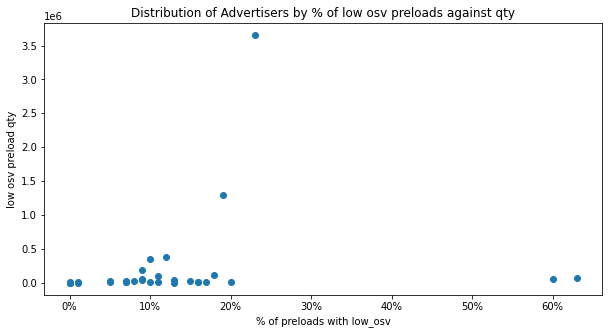

In [76]:
plt.figure(figsize = (10,5))
axes = plt.gca()
axes.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.scatter(by_advertiser['pct_loss'], by_advertiser['preload_low_osv'])
plt.xlabel('% of preloads with low_osv')
plt.ylabel('low osv preload qty')
plt.title('Distribution of Advertisers by % of low osv preloads against qty')

In [72]:
by_campaign_low_osv = df[(df.package_name.isin(packages_w_events)) & (df.low_osv)].pivot_table(values = ['preload'], index = ['partner_name','campaign_name'], aggfunc = np.sum)
by_campaign_all = df.pivot_table(values = ['preload'], index = ['partner_name','campaign_name'], aggfunc = np.sum)
by_campaign = by_campaign_all.join(by_campaign_low_osv, how = 'left', lsuffix = '_total', rsuffix = '_low_osv')
by_campaign['pct_loss'] = round(by_campaign['preload_low_osv']/(by_campaign['preload_total']),2)
by_campaign['sov'] = round(by_campaign['preload_total']/by_campaign['preload_total'].sum(),3)
by_campaign[by_campaign.sov >= .001].sort_values(['pct_loss','preload_total'], ascending = False).head(40)

preload_total  \
partner_name              campaign_name                                                       
King.com                  ccs_us_android_preload_ptest_ua                            216016   
                          ccs_in_android_preload_cpi_bau_lowcpi-2511-Ignite          333056   
                          fhs_co_android_preload_cpi_lowcpi-3076-Ignite               83520   
YOP OPERACIONES DE MEXICO Wabi-Android-18592-MX_AMX-ATT-SAMSUNG-Ignite_CPI            93040   
Wish                      Wish-Android-9425-BR-AMX-Ignite-CPI                        179024   
IFood Brasil              IFOOD-MID-LOW-END-ANDROID-17047-BR-AMX-IGNITE-CPI           78704   
King.com                  fhs_mx_android_preload_cpi_lowcpi-3076-Ignite              449120   
Wish                      Wish-Android-9425-MX-AMX-Ignite-CPI                        764736   
Playtika                  DT_SM_Android_ROW_Ignite_CPI_Performance                   240128   
Wish                      Wish-Android-9425-MX-OM-Ignite-CPI                         448608   
EA Mobile                 EA_ FIFAMB_ Android_ 18251_ LATAM_ Ignite_CPI              100224   
C&A                       C&A-Android-17466-BR-AMX-Ignite-CPI                        224208   
Zoom                      Buscape-Android-17279-BR-AMX-Ignite-CPI                     62048   
Wish                      Wish-Android-9425-Europe-Lenovo-Archos-BLU-Acer...         147184   
                          Wish-Android-9425-CL-AMX-Ignite-CPI                         74448   
                          Wish-Android-9425-CO-AMX-Ignite-CPI                        402336   
King.com                  fhs_row_android_preload_cpi_lowcpi-3076-Ignite            1499904   
IFood Brasil              IFOOD-DTOM-ANDROID-17047-BR-AMX-IGNITE-CPI                  90608   
King.com                  ccs_row_android_preload_cpi_bau_lowcpi-2511-Ignite        4379360   
                          ccs_us_DTOM_android_preload_cpi_bau-2511-Ignite            122288   
                          ccs_co_android_preload_cpi_bau_lowcpi-2511-Ignite          399536   
GSN Games                 GSNC010644_DTOM_US_Tripeaks                                210032   
Wish                      Wish-Android-9425-US-OM-Ignite-CPI                         224432   
King.com                  ccs_mx_android_preload_cpi_bau_lowcpi-2511-Ignite         1288576   
Gram Games Limited        DT_mergedragons_US_android_Preload_Silent_DTOM-...         237568   
King.com                  fhs_us_android_preload_VZW_cpi_ptest-3076-Ignite           152464   
                          ccs_us_android_preload_USCC_cpi_bau-2511-Ignite             93792   
Playtika                  DT_SM_Android_US_ATT_Silent_Ignite_CPI_Performance          78656   
Wish                      Wish-Android-9425-US-VZW-Ignite-CPI                        406944   
                          Wish-Android-9425-US-Tracfone-Ignite-CPI                   346464   
King.com                  ccss_us_android_preload_USCC_cpi_bau-5093-Ignite            88448   
                          ccss_us_android_preload_AppSelect_cpi_bau-5093-...          62672   
Playtika                  DT_SM_Android_US_VZW_Ignite_CPI_Performance                162544   
Wish                      Wish-Android-9425-US-USCC-Ignite-CPI                       102112   
King.com                  ccss_us_android_preload_DTOM_cpi_bau-5093-Ignite            71728   
                          ccss_us_android_preload_ATT_cpi_bau-5093-Ignite            235040   
                          prs_us_android_preload_ATT_cpi_bau-2511-Ignite_...          68176   
DoorDash                  CX_US_DI_AD_DT_ACQ_CUSXXX__+DOORDASH_ACQ_DIGITA...          65472   
King.com                  fhs_br_android_preload_cpi_lowcpi-3076-Ignite              346064   
GSN Games                 SolitaireTriPeaks-Android-15050-US_USCC_Ignite_CPP         146896   

                                                                              preload_l

In [11]:
plt.figure(figsize = (10,5))
axes = plt.gca()
axes.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.scatter(by_campaign['pct_loss'], by_campaign['preload_low_osv'])
plt.xlabel('% of preloads with low_osv')
plt.ylabel('low osv preload qty')
plt.title('Distribution of Campaigns by % of low osv preloads against qty')

Text(0.5, 1.0, 'Distribution of Campaigns by % of low osv preloads against qty')

In [53]:
by_country_low_osv = df[(df.package_name.isin(packages_w_events)) & (df.low_osv)].pivot_table(values = ['preload'], index = 'country_code', aggfunc = np.sum)
by_country_all = df.pivot_table(values = ['preload'], index = 'country_code', aggfunc = np.sum)
by_country = by_country_all.join(by_country_low_osv, how = 'left', lsuffix = '_total', rsuffix = '_low_osv')
by_country['pct_loss'] = round(by_country['preload_low_osv']/(by_country['preload_total']),2)
by_country['sov'] = round(by_country['preload_total']/by_country['preload_total'].sum(),3)
by_country[by_country.sov >= .001].sort_values(['pct_loss','preload_total'], ascending = False).head(30)

preload_total  preload_low_osv  pct_loss    sov
country_code                                                 
HT                   139872          60544.0      0.43  0.001
VE                   292528          82960.0      0.28  0.002
DO                   617408         117024.0      0.19  0.005
NI                   225792          37840.0      0.17  0.002
SV                   606784          78368.0      0.13  0.005
HN                   626624          77840.0      0.12  0.005
RU                    73424           8464.0      0.12  0.001
IN                  3277152         330720.0      0.10  0.027
PK                   319904          31696.0      0.10  0.003
BO                   118688          12208.0      0.10  0.001
JM                   118416          12416.0      0.10  0.001
GH                    70048           7344.0      0.10  0.001
CO                  4867904         447296.0      0.09  0.040
PY                   137328          12288.0      0.09  0.001
GT                   834304          63312.0      0.08  0.007
CR                   220896          17248.0      0.08  0.002
TH                   111216           8912.0      0.08  0.001
MX                 24497856        1781520.0      0.07  0.203
EC                   714672          49728.0      0.07  0.006
CA                   128880           9488.0      0.07  0.001
PE                  4248368         237488.0      0.06  0.035
CL                  1130960          71344.0      0.06  0.009
FR                   444096          27296.0      0.06  0.004
PA                   233072          13920.0      0.06  0.002
PR                   159920          10048.0      0.06  0.001
NG                    95488           6192.0      0.06  0.001
GB                   362064          17632.0      0.05  0.003
BD                   123520           6368.0      0.05  0.001
CN                    69776           3712.0      0.05  0.001
US                 52660320        2010224.0      0.04  0.436

Text(0.5, 1.0, 'Distribution of Countries by % of low osv preloads against qty')

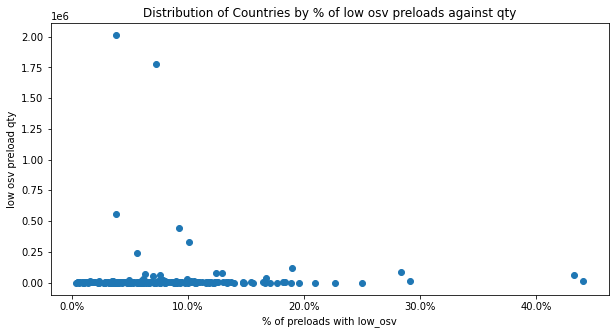

In [13]:
plt.figure(figsize = (10,5))
axes = plt.gca()
axes.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.scatter(by_country['pct_loss'], by_country['preload_low_osv'])
plt.xlabel('% of preloads with low_osv')
plt.ylabel('low osv preload qty')
plt.title('Distribution of Countries by % of low osv preloads against qty')

In [54]:
by_carrier_low_osv = df[(df.package_name.isin(packages_w_events)) & (df.low_osv)].pivot_table(values = ['preload'], index = 'carrier_name_no_country', aggfunc = np.sum)
by_carrier_all = df.pivot_table(values = ['preload'], index = 'carrier_name_no_country', aggfunc = np.sum)
by_carrier = by_carrier_all.join(by_carrier_low_osv, how = 'left', lsuffix = '_total', rsuffix = '_low_osv')
by_carrier['pct_loss'] = round(by_carrier['preload_low_osv']/(by_carrier['preload_total']),2)
by_carrier['sov'] = round(by_carrier['preload_total']/by_carrier['preload_total'].sum(),3)
by_carrier[by_carrier.sov >= .001].sort_values(['pct_loss','preload_total'], ascending = False).head(30)

preload_total  preload_low_osv  pct_loss  \
carrier_name_no_country                                                        
DT Lenovo LatAm                            432416         307168.0      0.71   
DT Archos                                  126272          51568.0      0.41   
DT Acer                                    129792          29168.0      0.22   
DT Blu                                    1285184         253056.0      0.20   
DT Lenovo                                 1344928         193280.0      0.14   
DT Reliance                                580496          81424.0      0.14   
DT Carrier Unallocated                   21757152        2305024.0      0.11   
DT Millicom                                854592          92128.0      0.11   
DT America Movil                         18669584        1236864.0      0.07   
DT Lava                                   1256144          93840.0      0.07   
DT Gionee                                  817984          53424.0      0.07   
DT Sliide                                  276208          17792.0      0.06   
DT Cellular                               2146688         113264.0      0.05   
DT AT&T                                  10223232         383984.0      0.04   
DT SingleTap                              5236624         216640.0      0.04   
DT Verizon                               14299424         421504.0      0.03   
DT Cricket                               10637872         280368.0      0.03   
DT Tracfone                               9369200         270096.0      0.03   
DT iTel                                    626640           5808.0      0.01   
DT AT&T Mexico                             279920           2112.0      0.01   
DT Samsung                               19826512          43888.0      0.00   
DT TIM                                     242000            208.0      0.00   
DT MyPhone - My Solid Technologies         139136            272.0      0.00   
DT Nokia                                    75744              NaN       NaN   

                                      sov  
carrier_name_no_country                    
DT Lenovo LatAm                     0.004  
DT Archos                           0.001  
DT Acer                             0.001  
DT Blu                              0.011  
DT Lenovo                           0.011  
DT Reliance                         0.005  
DT Carrier Unallocated              0.180  
DT Millicom                         0.007  
DT America Movil                    0.155  
DT Lava                             0.010  
DT Gionee                           0.007  
DT Sliide                           0.002  
DT Cellular                         0.018  
DT AT&T                             0.085  
DT SingleTap                        0.043  
DT Verizon                          0.118  
DT Cricket                          0.088  
DT Tracfone                         0.078  
DT iTel                             0.005  
DT AT&T Mexico                      0.002  
DT Samsung                          0.164  
DT TIM                              0.002  
DT MyPhone - My Solid Technologies  0.001  
DT Nokia                            0.001

In [15]:
plt.figure(figsize = (10,5))
axes = plt.gca()
axes.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.scatter(by_carrier['pct_loss'], by_carrier['preload_low_osv'])
plt.xlabel('% of preloads with low_osv')
plt.ylabel('low osv preload qty')
plt.title('Distribution of Carriers by % of low osv preloads against qty')

Text(0.5, 1.0, 'Distribution of Carriers by % of low osv preloads against qty')

In [60]:
by_site_low_osv = df[(df.package_name.isin(packages_w_events)) & (df.low_osv)].pivot_table(values = ['preload'], index = ['carrier_name','site_name'], aggfunc = np.sum)
by_site_all = df.pivot_table(values = ['preload'], index = ['carrier_name','site_name'], aggfunc = np.sum)
by_site = by_site_all.join(by_site_low_osv, how = 'left', lsuffix = '_total', rsuffix = '_low_osv')
by_site['pct_loss'] = round(by_site['preload_low_osv']/(by_site['preload_total']),2)
by_site['sov'] = round(by_site['preload_total']/by_site['preload_total'].sum(),3)
by_site[by_site.sov >= .001].sort_values(['pct_loss','preload_total'], ascending = False).head(30)

preload_total  \
carrier_name           site_name                                                           
DT Lenovo LatAm        DT - Lenovo - Ignite - Motorola - LatAm - Silent           432416   
DT Carrier Unallocated DT - DTOM - AMX - Multi - Ignite - SR                      285392   
                       DT - DTOM - Millicom - Multi - Ignite - SR                 117952   
DT Lava                DT - Lava - IN - Ignite - Z51 - Silent                      82800   
DT Verizon             DT - Verizon - US - Ignite - TCL - 5059S                    68672   
                       DT - Verizon - US - Ignite - Samsung - S7 - SM-...         183328   
DT Tracfone            DT - Tracfone - Ignite - Alcatel - A501DL                  126624   
DT Lenovo              DT - Lenovo - Ignite - Motorola - George - Moto...         289824   
DT Millicom            DT - Millicom - CO - Ignite - Silent - Tier 1               87200   
DT AT&T                DT - ATT - US - Ignite - LG - Phoenix 4 - LM-X2...         100880   
DT America Movil CO    DT - AMX - CO - Ignite - Mid-range                          92624   
DT Tracfone            DT - Tracfone - Ignite - Alcatel - A503DL                   72144   
                       DT - Tracfone - Ignite - Alcatel - A502DL                  136640   
DT America Movil BR    DT - AMX - BR - Ignite - High End                           64848   
DT Cricket             DT - Cricket - US - Ignite - Motorola - E5 Crui...         264000   
DT Gionee              DT - Gionee - IN - Ignite - F205 - Silent                  138672   
DT Acer                DT - Acer - Multi - Ignite - Acer Asgard - Silent           64384   
DT Tracfone            DT - Tracfone - Ignite - LG - L211BL                        88384   
DT Carrier Unallocated DT - DTOM - Millicom - Multi - Ignite - All Dev...         234944   
                       DT - DTOM - ATT - Multi - Ignite - All Devices             824304   
                       DT - DTOM - CRKT - Multi - Ignite - All Devices            430528   
DT Lava                DT - Lava - IN - Ignite - Z61 - Silent                     137424   
DT Blu                 DT - Blu - Multi - Ignite - Blu GO Basic - Silent         1215456   
DT Tracfone            DT - Tracfone - Ignite - LG - L212VL                       172560   
DT Carrier Unallocated DT - DTOM - VZW - Multi - Ignite - All Devices            1232320   
DT Reliance            DT - Reliance - IN - Ignite - LYF LS-4505                  125840   
DT Cricket             DT - Cricket - US - Ignite - LG - Fortune 2 - L...          89728   
DT Reliance            DT - Reliance -  IN- Ignite - LS- 4508                      75264   
DT Gionee              DT - Gionee - IN - Ignite - F205Pro - Silent                74656   
DT Lava                DT - Lava - IN - Ignite - Z60s - Silent                     66800   

                                                                           preload_low_osv  \
carrier_name           site_name                                                             
DT Lenovo LatAm        DT - Lenovo - Ignite - Motorola - LatAm - Silent           307168.0   
DT Carrier Unallocated DT - DTOM - AMX - Multi - Ignite - SR                      172928.0   
                       DT - DTOM - Millicom - Multi - Ignite - SR                  67856.0   
DT Lava                DT - Lava - IN - Ignite - Z51 - Silent                      32608.0   
DT Verizon             DT - Verizon - US - Ignite - TCL - 5059S                    26688.0   
                       DT - Verizon - US - Ignite - Samsung - S7 - SM-...          66928.0   
DT Tracfone            DT - Tracfone - Ignite - Alcatel - A501DL                   45600.0   
DT Lenovo              DT - Lenovo - Ignite - Motorola - George - Moto...          96096.0   
DT Millicom            DT - Millicom - CO - Ignite - Silent - Tier 1               27856.0   
DT AT&T                DT - ATT - US - Ignite - LG - Phoenix 4 - LM-X2...          30320.0   
DT

Text(0.5, 1.0, 'Distribution of Sites by % of low osv preloads against qty')

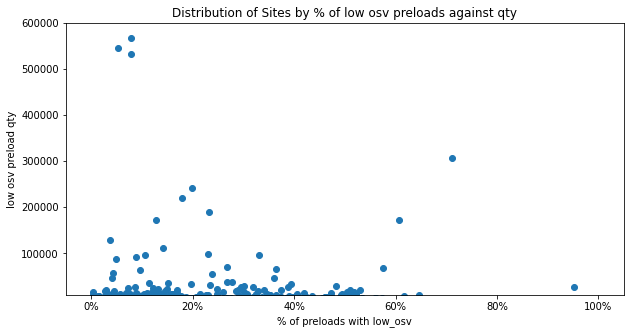

In [17]:
plt.figure(figsize = (10,5))
axes = plt.gca()
axes.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.scatter(by_site['pct_loss'], by_site['preload_low_osv'])
plt.xlabel('% of preloads with low_osv')
plt.ylabel('low osv preload qty')
plt.ylim(10000,600000)
plt.title('Distribution of Sites by % of low osv preloads against qty')

In [63]:
by_site_country_low_osv = df[(df.package_name.isin(packages_w_events)) & (df.low_osv)].pivot_table(values = ['preload'], index = ['country_code','site_name'], aggfunc = np.sum)
by_site_country_all = df.pivot_table(values = ['preload'], index = ['country_code','site_name'], aggfunc = np.sum)
by_site_country = by_site_country_all.join(by_site_country_low_osv, how = 'left', lsuffix = '_total', rsuffix = '_low_osv')
by_site_country['pct_loss'] = round(by_site_country['preload_low_osv']/(by_site_country['preload_total']),2)
by_site_country['sov'] = round(by_site_country['preload_total']/by_site_country['preload_total'].sum(),3)
by_site_country[by_site_country.sov >= .001].sort_values(['pct_loss','preload_total'], ascending = False).head(30)


preload_total  \
country_code site_name                                                           
BR           DT - Lenovo - Ignite - Motorola - LatAm - Silent           291504   
MX           DT - DTOM - AMX - Multi - Ignite - SR                      168112   
CO           DT - DTOM - Millicom - Multi - Ignite - SR                  61616   
MX           DT - Lenovo - Ignite - Motorola - LatAm - Silent            86736   
US           DT - Verizon - US - Ignite - TCL - 5059S                    68672   
CO           DT - DTOM - Millicom - Multi - Ignite - All Dev...         114704   
US           DT - Verizon - US - Ignite - Samsung - S7 - SM-...         183328   
             DT - Tracfone - Ignite - Alcatel - A501DL                  126448   
IN           DT - Lenovo - Ignite - Motorola - George - Moto...         289824   
CO           DT - Millicom - CO - Ignite - Silent - Tier 1               87152   
US           DT - ATT - US - Ignite - LG - Phoenix 4 - LM-X2...         100880   
             DT - DTOM - ATT - Multi - Ignite - All Devices             201664   
CO           DT - AMX - CO - Ignite - Mid-range                          92448   
US           DT - Tracfone - Ignite - Alcatel - A503DL                   72112   
BR           DT - AMX - BR - Ignite - High End                           64640   
US           DT - Tracfone - Ignite - Alcatel - A502DL                  136640   
DO           DT - DTOM - ATT - Multi - Ignite - All Devices              85712   
MX           DT - Blu - Multi - Ignite - Blu GO Basic - Silent          283600   
US           DT - Cricket - US - Ignite - Motorola - E5 Crui...         264000   
IN           DT - Gionee - IN - Ignite - F205 - Silent                  138384   
DO           DT - DTOM - CRKT - Multi - Ignite - All Devices             73744   
US           DT - Tracfone - Ignite - LG - L211BL                        88288   
PK           DT - DTOM - VZW - Multi - Ignite - All Devices              73872   
DO           DT - DTOM - VZW - Multi - Ignite - All Devices              80880   
IN           DT - Lava - IN - Ignite - Z61 - Silent                     136496   
VE           DT - Blu - Multi - Ignite - Blu GO Basic - Silent          130640   
BR           DT - DTOM - AMX - Multi - Ignite - All Device              619632   
US           DT - Tracfone - Ignite - LG - L212VL                       172080   
             DT - DTOM - VZW - Multi - Ignite - All Devices             319824   
NI           DT - Blu - Multi - Ignite - Blu GO Basic - Silent          106432   

                                                                 preload_low_osv  \
country_code site_name                                                             
BR           DT - Lenovo - Ignite - Motorola - LatAm - Silent           254768.0   
MX           DT - DTOM - AMX - Multi - Ignite - SR                      106720.0   
CO           DT - DTOM - Millicom - Multi - Ignite - SR                  27008.0   
MX           DT - Lenovo - Ignite - Motorola - LatAm - Silent            37696.0   
US           DT - Verizon - US - Ignite - TCL - 5059S                    26688.0   
CO           DT - DTOM - Millicom - Multi - Ignite - All Dev...          44096.0   
US           DT - Verizon - US - Ignite - Samsung - S7 - SM-...          66928.0   
             DT - Tracfone - Ignite - Alcatel - A501DL                   45600.0   
IN           DT - Lenovo - Ignite - Motorola - George - Moto...          96096.0   
CO           DT - Millicom - CO - Ignite - Silent - Tier 1               27856.0   
US           DT - ATT - US - Ignite - LG - Phoenix 4 - LM-X2...          30320.0   
             DT - DTOM - ATT - Multi - Ignite - All Devices              57904.0   
CO           DT - AMX - CO - Ignite - Mid-range                          27184.0   
US           DT - Tracfone - Ignite - Alcatel - A503DL                   20848.0   
BR           DT - AMX - BR - Ignite - High End                           18464.0   
US          

Text(0.5, 1.0, 'Distribution of Sites/Countries by % of low osv preloads against qty')

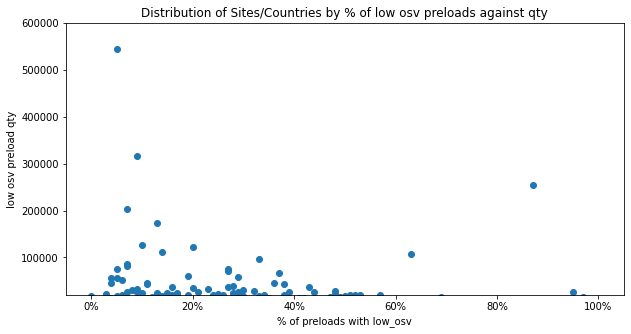

In [78]:
plt.figure(figsize = (10,5))
axes = plt.gca()
axes.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.scatter(by_site_country['pct_loss'], by_site_country['preload_low_osv'])
plt.xlabel('% of preloads with low_osv')
plt.ylabel('low osv preload qty')
plt.ylim(20000,600000)
plt.title('Distribution of Sites/Countries by % of low osv preloads against qty')